In [92]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import eig
from tqdm import tqdm
from ryu_tool import mytool

In [2]:
# 필요한 파일을 불러옵니다
stock_price = pd.read_pickle("Data/allstock_reduced.pickle")
spy_mask = pd.read_pickle("Data/spx_mask.pickle")

In [109]:
class PortfolioOptimzer:
    def __init__(self, price, spx_mask):
        '''
        Initialize the data (price: Price DataFrame 
                             spx_mask : S&P500 mask DataFrame)
        '''
        self.price = price
        self.spx_mask = spx_mask
        self.rtn = price.pct_change(fill_method=None)

    def __obj_min_variance(self, weight, cov_matrix):
        '''목적 함수 정의(최소 분산)'''
        return np.dot(weight.T, np.dot(cov_matrix, weight))
    
    def __no_shrinkage(self, corr_matrix, args):
        return corr_matrix
    
    def __linear_shrinkage(self, corr_matrix, alpha:int): # cov_matrix를 corr_matrix로 변환하는 과정이 필요함!
        '''Method of A'''
        return  alpha * np.identity(corr_matrix.shape[0]) + (1-alpha) * corr_matrix
    
    def __constant_correlation_model(self, corr_matrix, args): # cov_matrix를 corr_matrix로 변환하는 과정이 필요함!
        '''Method B'''
        n = len(corr_matrix)
        sum_r = np.sum(corr_matrix).sum() - np.sum(np.diag(corr_matrix)).sum()
        r = sum_r / (n*(n-1))
        return np.full(corr_matrix.shape, fill_value=r) - ((r-1) * np.identity(n))
    
    def __eigenvalue_clipping(self, corr_matrix, k:int): # cov_matrix를 corr_matrix로 변환
        '''Method C'''
        eigen_value, eigen_vector = np.linalg.eigh(corr_matrix)
        eigen_value_bigger = np.where(eigen_value >= k, eigen_value, 0)
        eigen_value_smaller = eigen_value[eigen_value_bigger == 0]
        eigen_value_otherwise = np.nanmean(eigen_value_smaller)
        # Result
        eigen_value_clipped = np.where(eigen_value >= k, eigen_value_bigger, eigen_value_otherwise)
        rt = eigen_vector @ np.diag(eigen_value_clipped) @ eigen_vector.T
        return eigen_vector @ np.diag(eigen_value_clipped) @ eigen_vector.T
    
    
    def run_optimizer(self, start_year:str, end_year:str, rebalancing:str, args=None, shrinkage_method="None"):
        '''
        포트폴리오 최적화를 수행합니다
        start_year, end_year : 투자기간(start_year + 1년부터 실제 투자 시작)
        rebalancing : 리벨런싱 주기 str -> [M,2M, Q, Y 등등,,,]
        shrinkage_method : str -> [linear, constant, clipping]
        
        args : dict -> {"alpha":int} / {"k": int}
        args 설명 -> linear: alpha=int  / clipping: k=int 
        
        Return -> pf_rtn, weight_df
        '''
        shrink = {"None": self.__no_shrinkage,
                  "linear":self.__linear_shrinkage,
                  "constant":self.__constant_correlation_model,
                  "clipping":self.__eigenvalue_clipping}

        pf_value = 1
        constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
        # weight를 담을 dataframe
        weight_df = pd.DataFrame(index=self.rtn.index,
                              columns=self.rtn.columns)
        self.rebalancing_date = []
        
        pf_rtn = {}

        start_idx = pd.date_range(start_year,end_year, freq=f"{rebalancing}S")
        end_idx = pd.date_range(start_year,end_year, freq=f"{rebalancing}")

        for i in tqdm(range(len(end_idx))):
            if i + 1 == len(end_idx): #마지막날은 weight계산할 필요가 없음...
                break
            
            # start~end의 주가를 보고 포폴 구성
            start = (start_idx[i] - pd.Timedelta(days=365)).strftime("%Y-%m") 
            end = (start_idx[i] - pd.Timedelta(days=1))             
            self.rebalancing_date.append(start_idx[i]) # 리벨런싱한 날짜 저장 
            
            #print(f'{start}~{end} 주가를 보고 포트폴리오 구성')

            mask_sample = self.spx_mask.loc[:end].iloc[-1]
            universe = mask_sample.loc[~mask_sample.isna()].index # S&P500 구성종목을 가져옵니다
            rtn_sample = self.rtn.loc[start:end, universe]  # 이전 1년치 주가가 look back window
            rtn_vol = np.diag(rtn_sample.std())
            corr_matrix = rtn_sample.corr() # corr_matrix를 추정하고, optimizer에 넣기 전에 cov_matrix로 변환해야함
            
            if shrinkage_method == "None" or shrinkage_method == "constant":
                args = {"args":0}
            
            shrinked_corr_matrix = shrink[shrinkage_method](corr_matrix = corr_matrix, **args)
            cov_matrix = rtn_vol.dot(shrinked_corr_matrix).dot(rtn_vol)
                        
            bounds = tuple((0,1) for _ in range(len(rtn_sample.columns))) # 제약조건 setting
            initial_weights = np.ones(len(rtn_sample.columns)) / len(rtn_sample.columns)
            
            # 최적화 수행
            result = minimize(self.__obj_min_variance, 
                              initial_weights, 
                              args=(cov_matrix,),
                              method='SLSQP', 
                              constraints=constraints, 
                              bounds=bounds)
            min_variance_weights = result.x
            weight_df.loc[start_idx[i], universe] = min_variance_weights

            dollar_value = min_variance_weights * pf_value # 포트폴리오로 담을 각 주식의 달러가치
            # weight 계산한 당일 종가로 포트폴리오를 construct한다고 가정

            # 다음날부터 리벨런싱날 전까지 포트폴리오 성과 측정
            start_date, end_date = start_idx[i].strftime("%Y-%m"), end_idx[i].strftime("%Y-%m")
            rtn_sample2 = self.rtn.loc[start_date:end_date, universe]

            for date in rtn_sample2.index:
                if date > self.rtn.index[-1]:
                    break
                dollar_value = dollar_value * (1 + rtn_sample2.loc[date]) # dollar value 변화를 update
                pf_value = dollar_value.sum()
                weight_update = dollar_value / pf_value  # weight 변화를 추적
                weight_df.loc[date, universe] = weight_update
                pf_rtn[date.strftime("%Y-%m-%d")] = pf_value
        
        pf_rtn = pd.Series(pf_rtn)
        pf_rtn.index = pd.to_datetime(pf_rtn.index)
        pf_rtn[pf_rtn.index[0] - pd.Timedelta(days=1)] = 1
        pf_rtn = pf_rtn.sort_index().pct_change().fillna(0)
        
        print("Jobs Done...")
        print("You can check .rebalancing_date")
        
        return pf_rtn, weight_df

In [110]:
portfolio = PortfolioOptimzer(price=stock_price,
                              spx_mask=spy_mask)

In [112]:
pf_rtn, weight_df = portfolio.run_optimizer(start_year="2020",
                                            end_year="2023",
                                            rebalancing="Q",
                                            shrinkage_method="clipping",
                                            args={"k":5})

 92%|█████████▏| 11/12 [01:09<00:06,  6.34s/it]

Jobs Done...
You can check .rebalancing_date


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


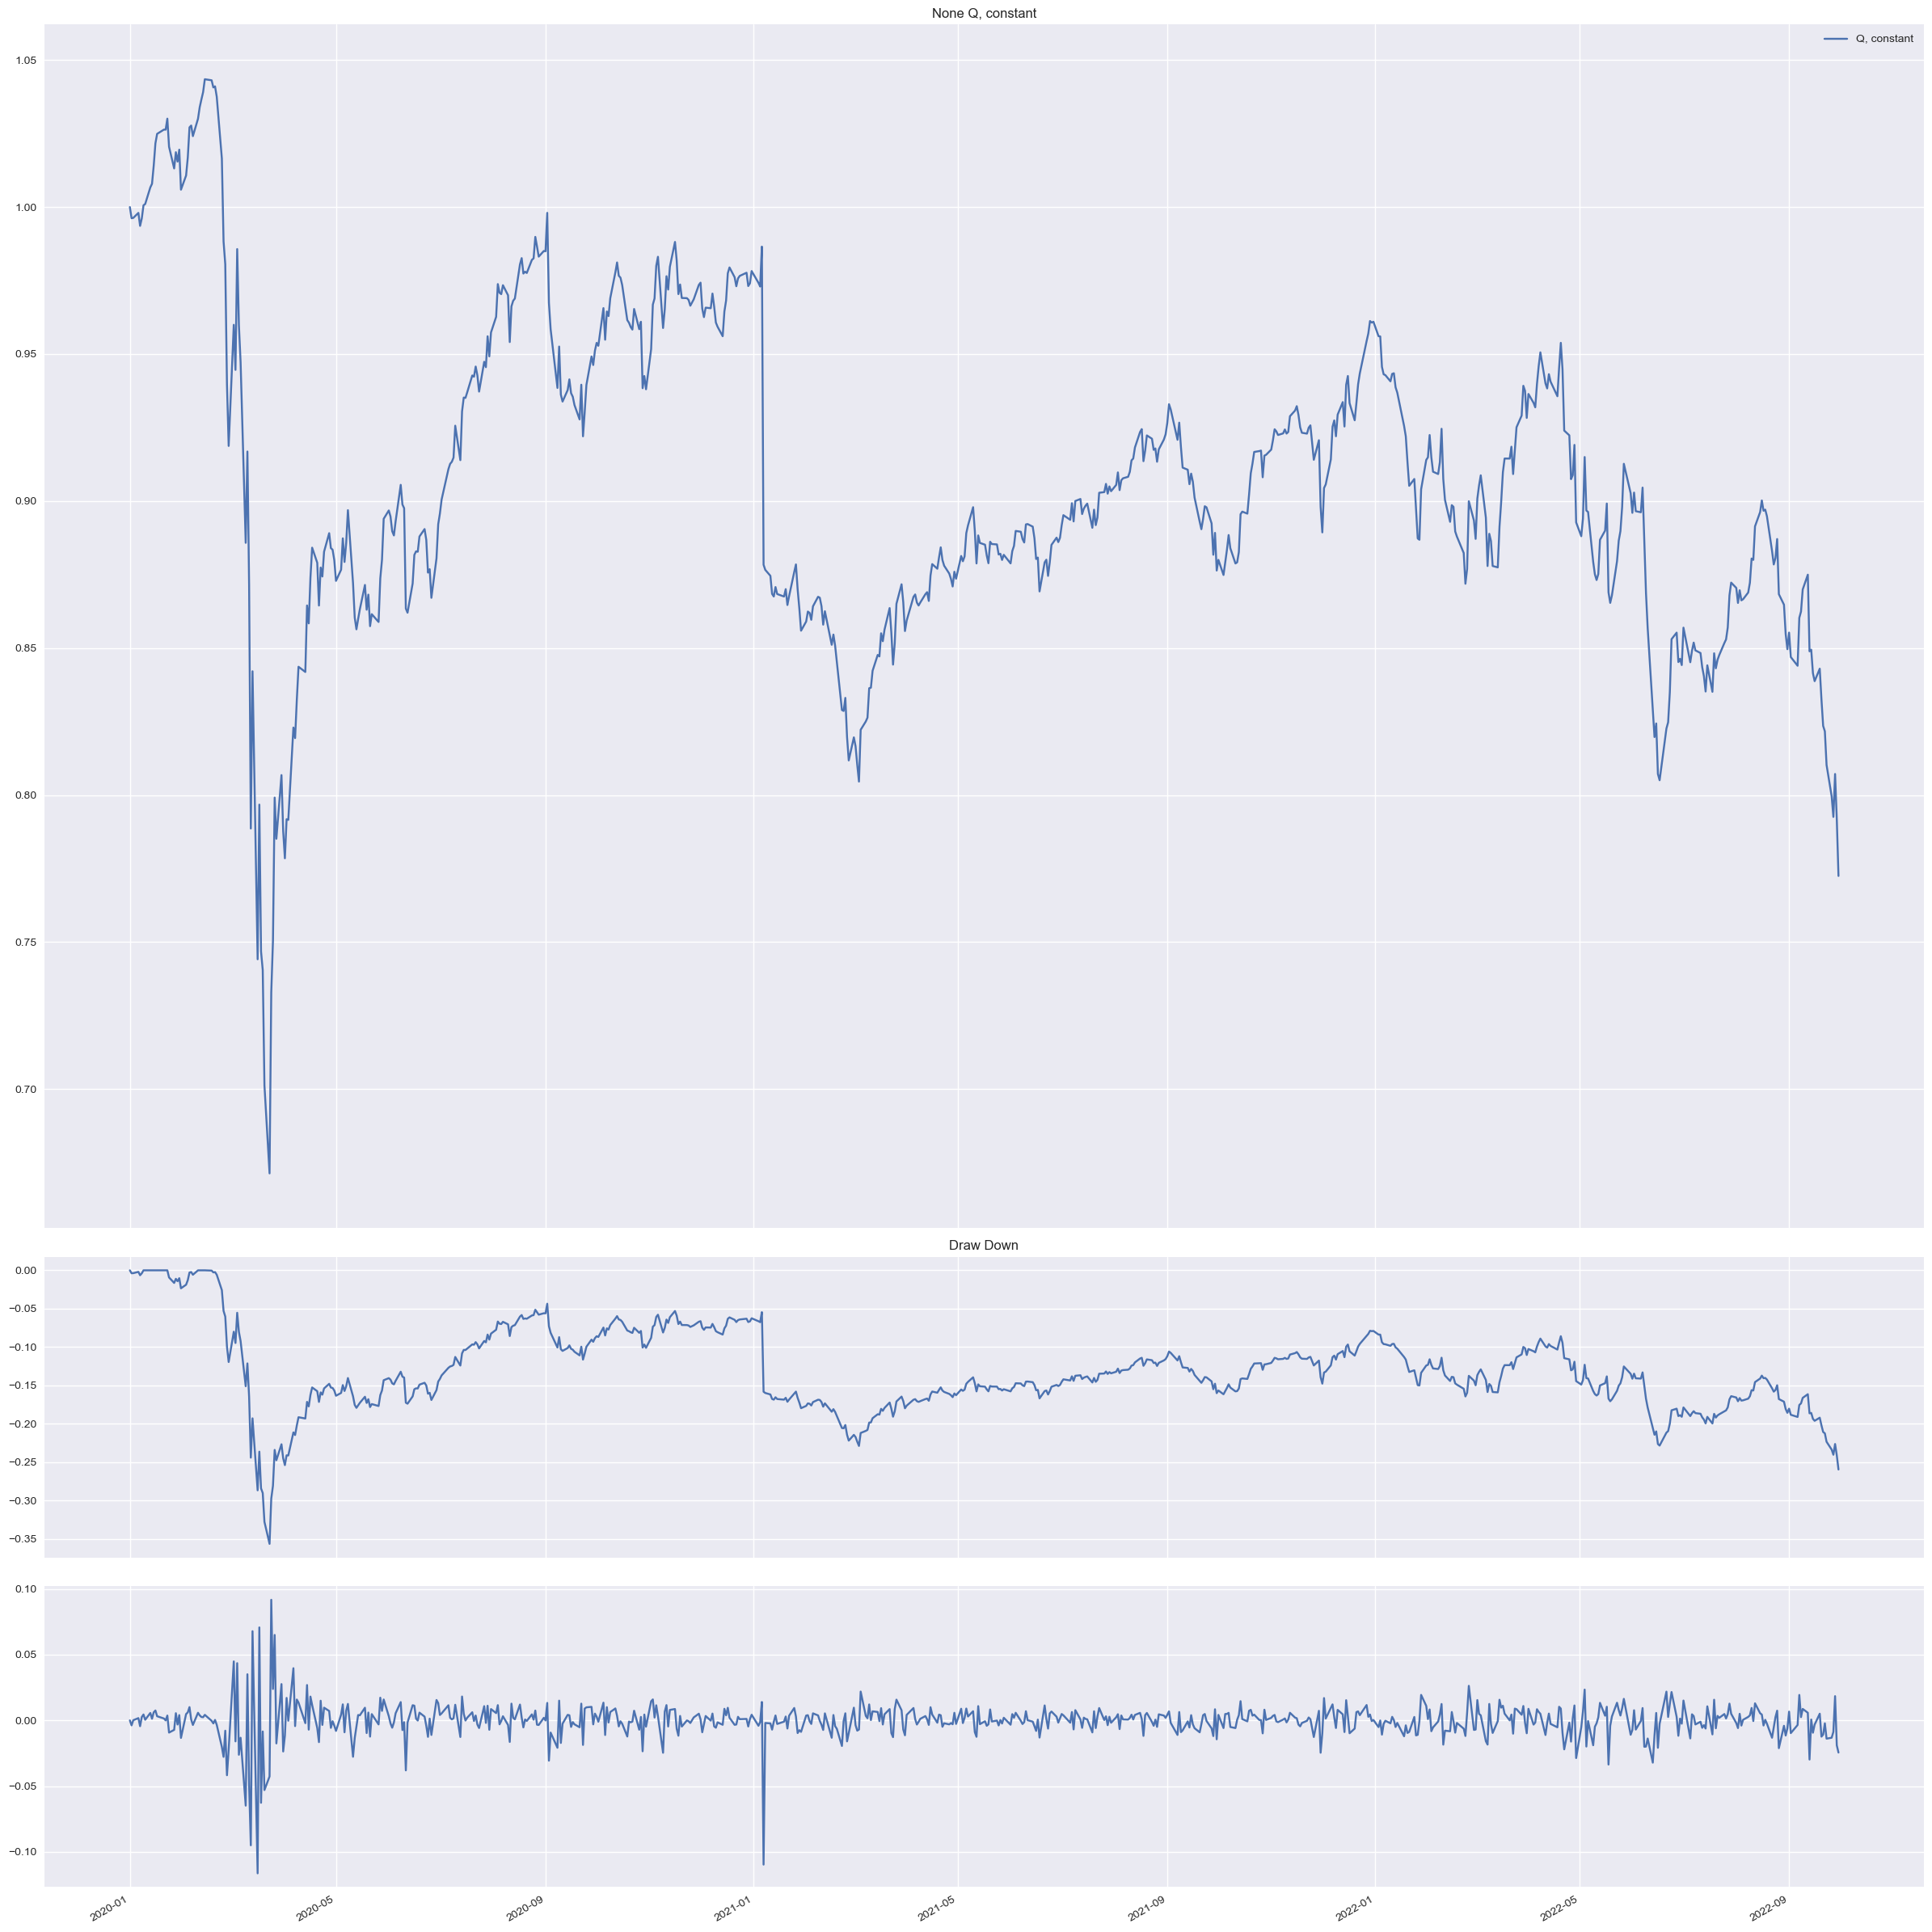

In [113]:
mytool.draw_return_result({"Q, constant": pf_rtn})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


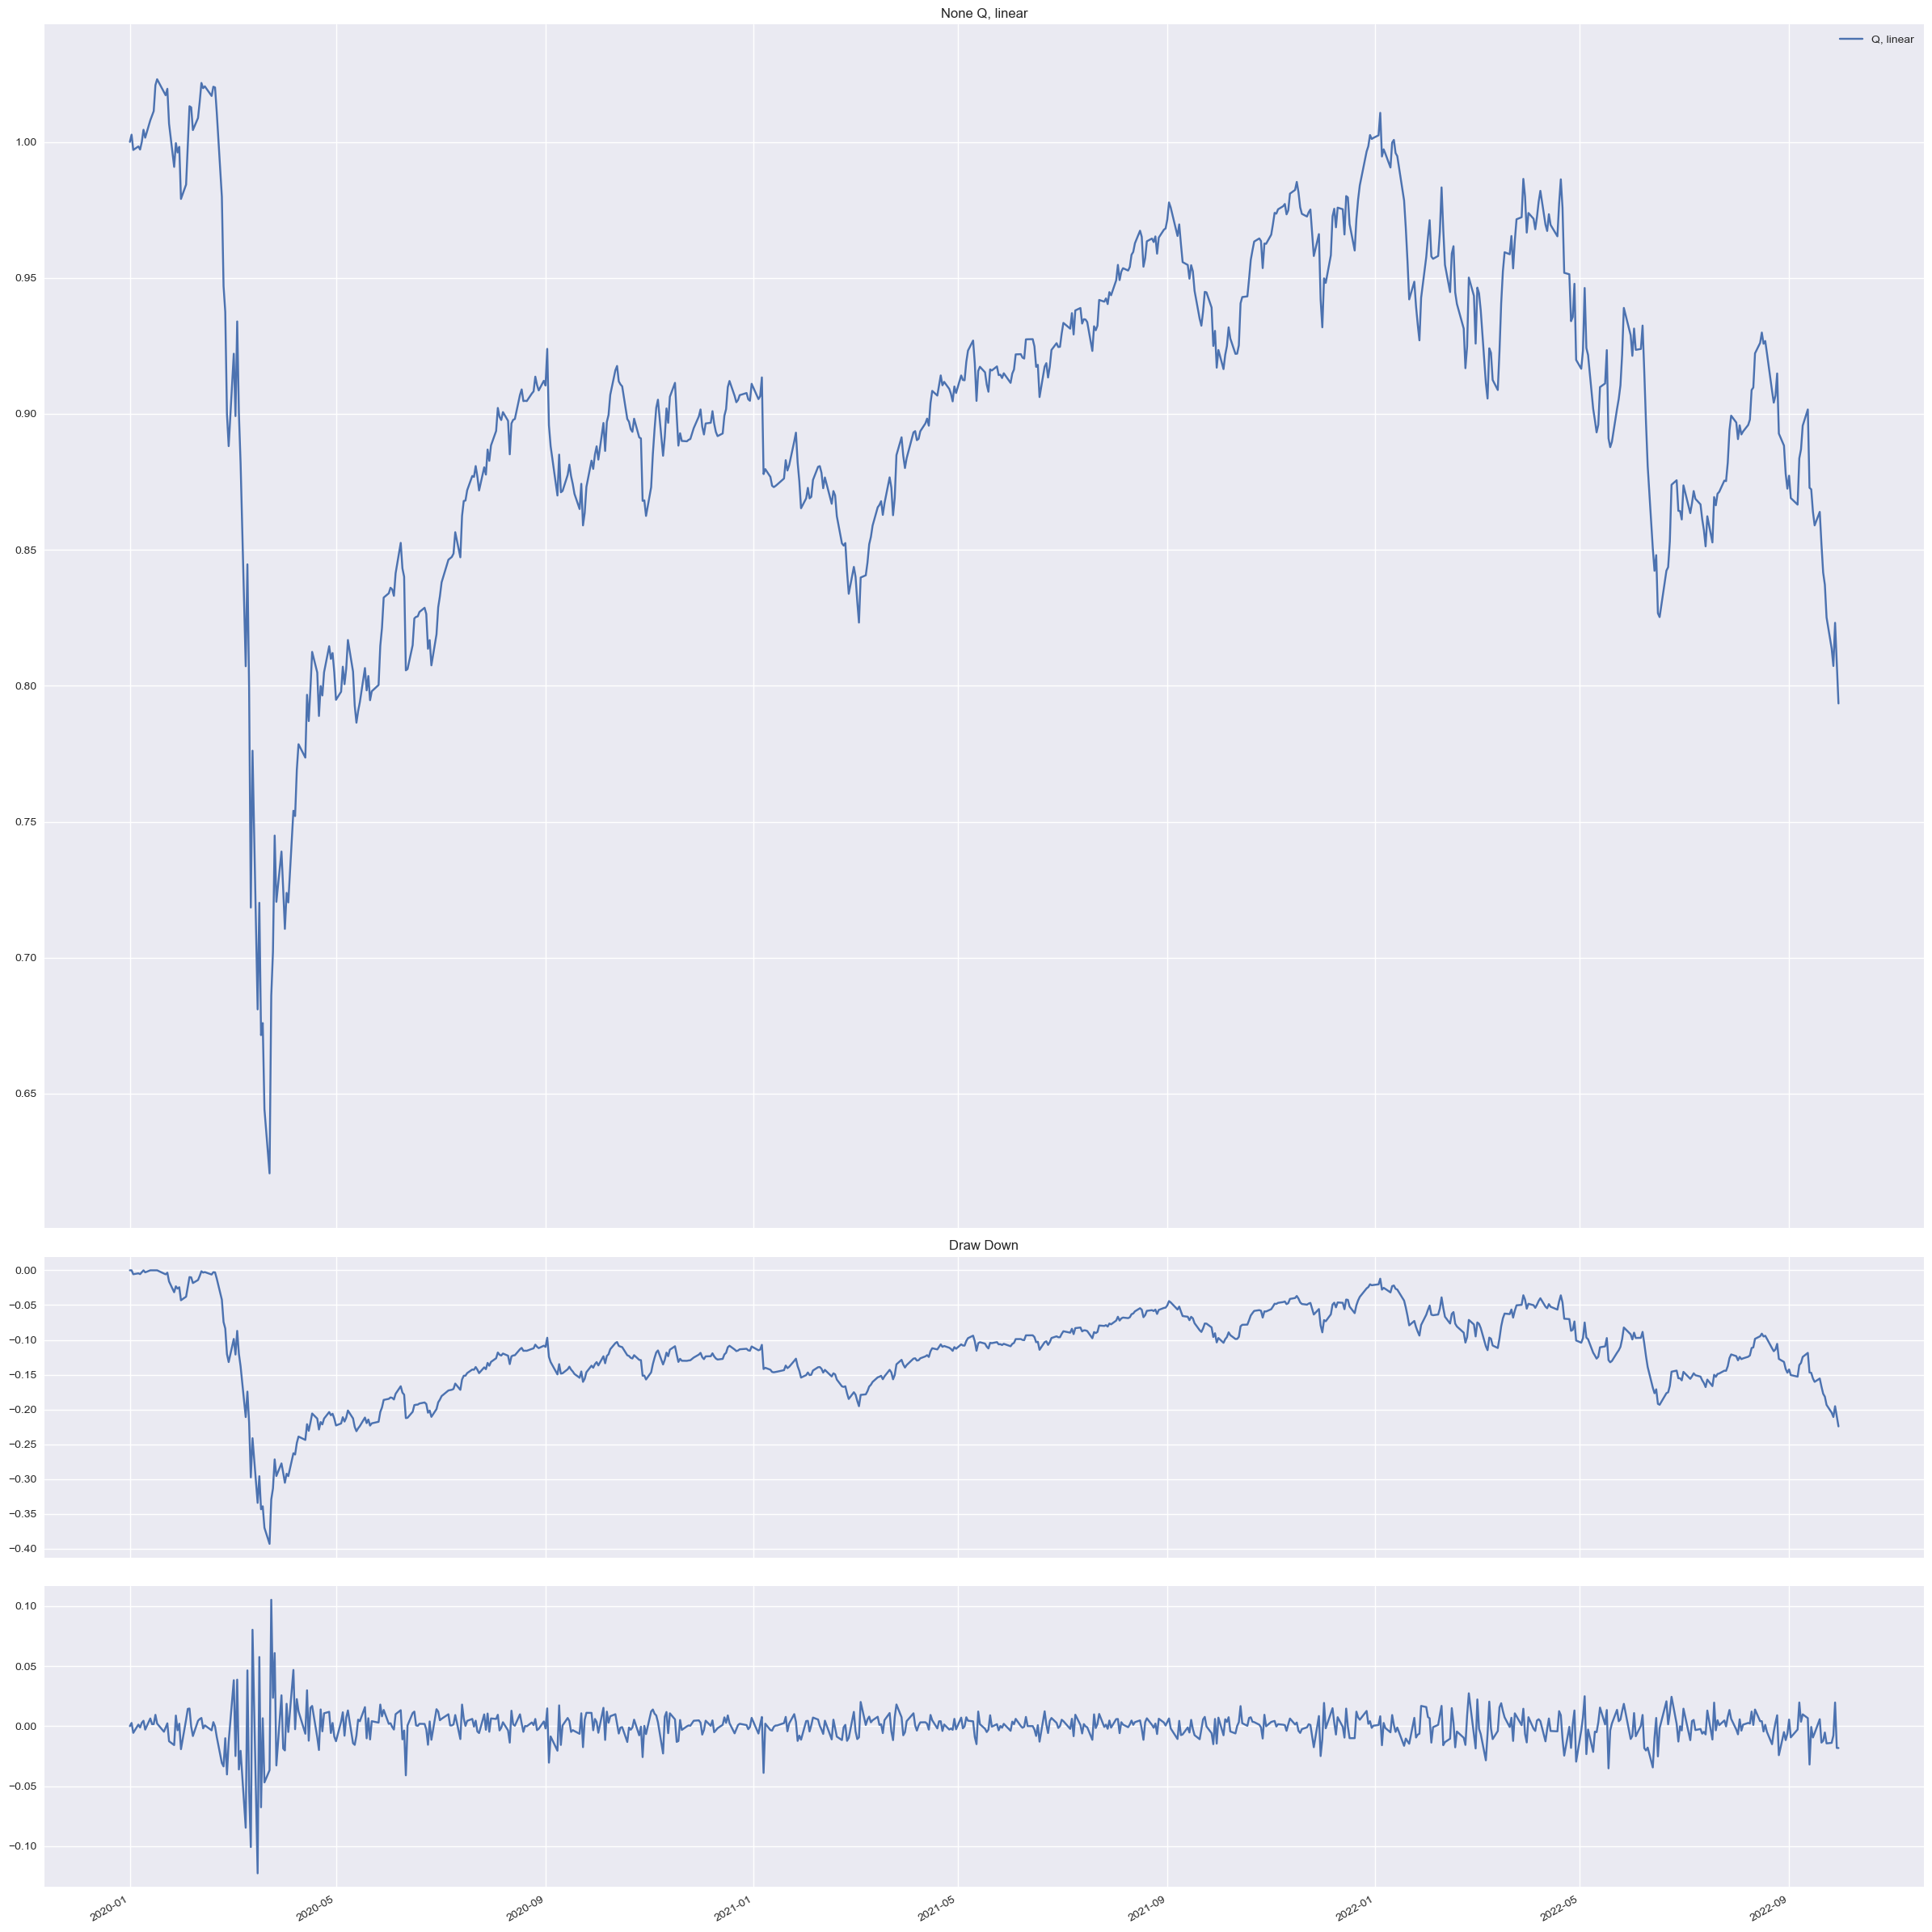

In [57]:
mytool.draw_return_result({"Q, linear": pf_rtn})

<AxesSubplot:xlabel='date'>

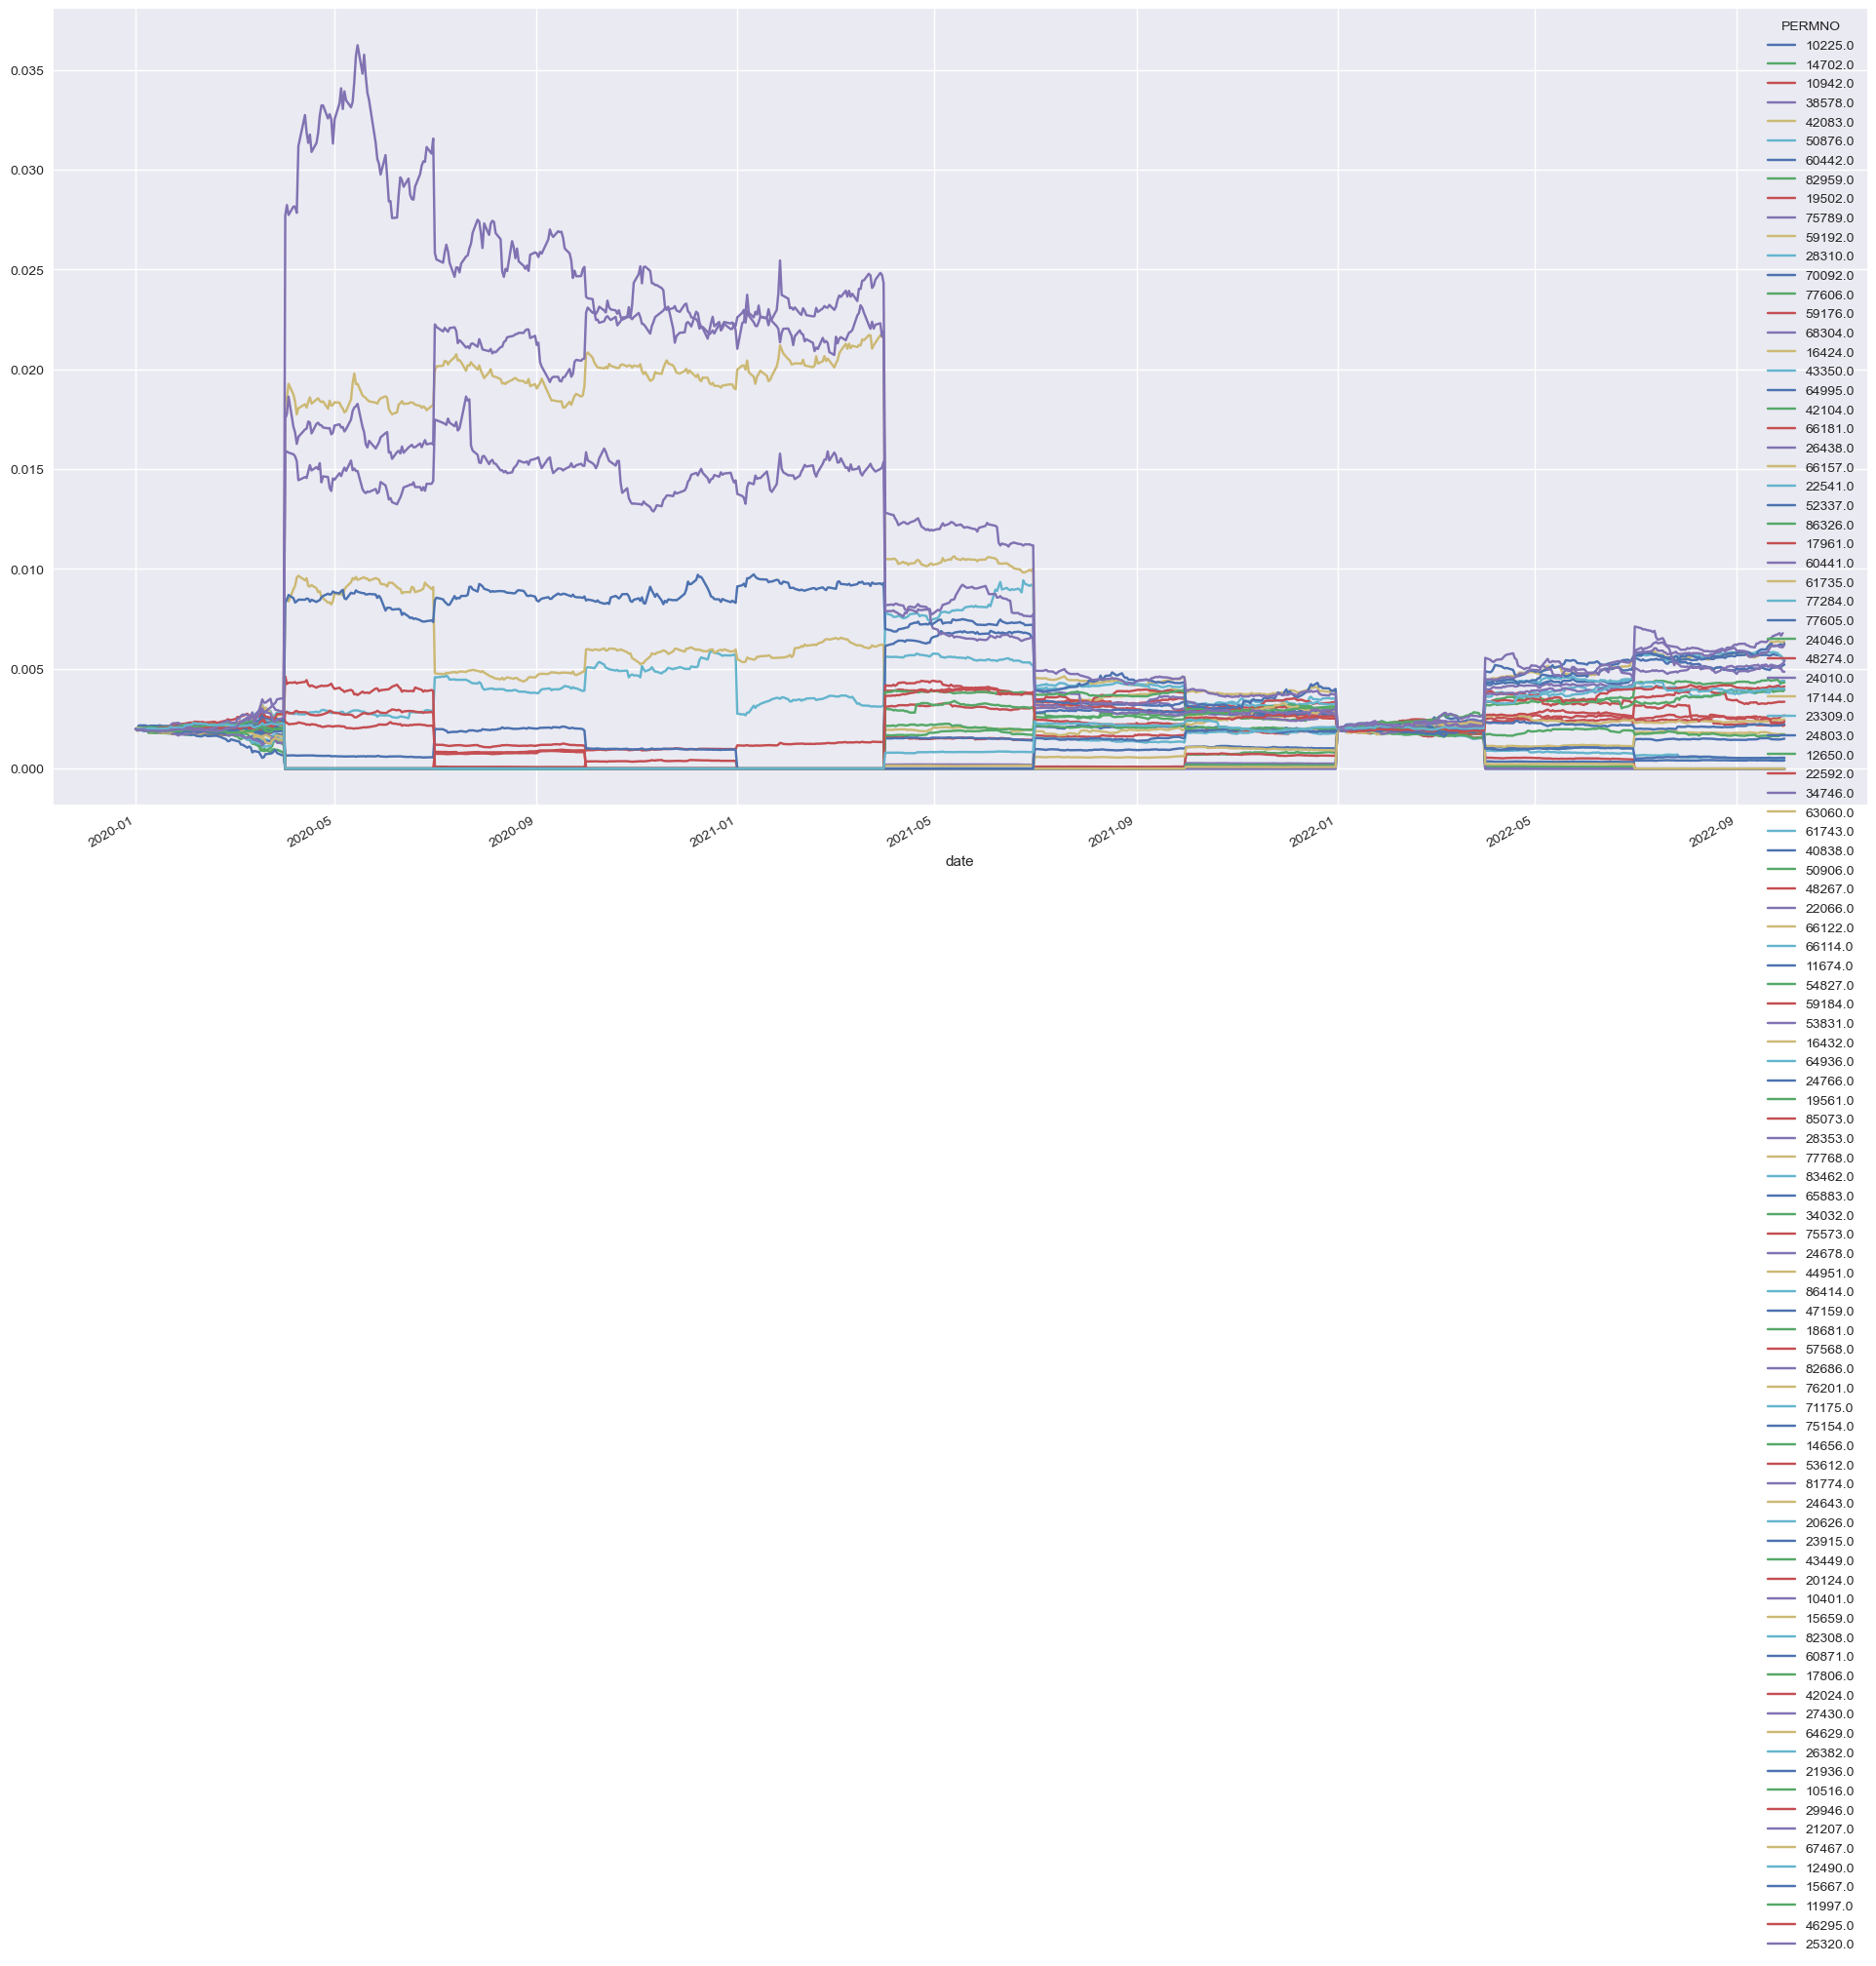

In [58]:
weight_df.iloc[:,:100].plot(figsize=(24,12))

In [7]:
#mytool.draw_return_result({"Min Variance Monthly Rebalancing" :r},
#                          title="")